In [1]:
import torch
from torch.nn import ModuleList
from gpytorch.module import Module

from abc import abstractmethod


def default_postprocess_script(x):
    return x



class Distance1(torch.nn.Module):
    def __init__(self, postprocess_script=default_postprocess_script):
        super().__init__()
        self._postprocess = postprocess_script

    def _sq_dist(self, x1, x2, postprocess, x1_eq_x2=False):
        
        res = torch.mul(torch.unsqueeze(x1, 1), torch.unsqueeze(x2, 0))

        if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
            pass
#             res.diagonal(dim1=-2, dim2=-1).fill_(0)

        # Zero out negative values
        res.clamp_min_(0)
        return self._postprocess(res) if postprocess else res

    def _dist(self, x1, x2, postprocess, x1_eq_x2=False):
        # TODO: use torch cdist once implementation is improved: https://github.com/pytorch/pytorch/pull/25799
        res = self._sq_dist(x1, x2, postprocess=False, x1_eq_x2=x1_eq_x2)
        res = res.clamp_min_(1e-30).sqrt_()
        return self._postprocess(res) if postprocess else res




class Kernel(Module):

    has_lengthscale = False

    def __init__(
        self,
        ard_num_dims=None,
        batch_shape=torch.Size([]),
        active_dims=None,
        lengthscale_prior=None,
        lengthscale_constraint=None,
        eps=1e-6,
        **kwargs,
    ):
        super(Kernel, self).__init__()
        self._batch_shape = batch_shape
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.register_buffer("active_dims", active_dims)
        self.ard_num_dims = ard_num_dims

        self.eps = eps

        param_transform = kwargs.get("param_transform")

        if lengthscale_constraint is None:
            lengthscale_constraint = Positive()

        if param_transform is not None:
            warnings.warn(
                "The 'param_transform' argument is now deprecated. If you want to use a different "
                "transformation, specify a different 'lengthscale_constraint' instead.",
                DeprecationWarning,
            )

        if self.has_lengthscale:
            lengthscale_num_dims = 1 if ard_num_dims is None else ard_num_dims
            self.register_parameter(
                name="raw_lengthscale",
                parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, lengthscale_num_dims)),
            )
            if lengthscale_prior is not None:
                self.register_prior(
                    "lengthscale_prior", lengthscale_prior, lambda m: m.lengthscale, lambda m, v: m._set_lengthscale(
                        v)
                )

            self.register_constraint("raw_lengthscale", lengthscale_constraint)

        self.distance_module = None
        # TODO: Remove this on next official PyTorch release.
        self.__pdist_supports_batch = True

    @abstractmethod
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        raise NotImplementedError()

    @property
    def batch_shape(self):
        kernels = list(self.sub_kernels())
        if len(kernels):
            return _mul_broadcast_shape(self._batch_shape, *[k.batch_shape for k in kernels])
        else:
            return self._batch_shape

    @batch_shape.setter
    def batch_shape(self, val):
        self._batch_shape = val

    @property
    def dtype(self):
        if self.has_lengthscale:
            return self.lengthscale.dtype
        else:
            for param in self.parameters():
                return param.dtype
            return torch.get_default_dtype()

    @property
    def is_stationary(self) -> bool:
        """
        Property to indicate whether kernel is stationary or not.
        """
        return self.has_lengthscale

    @property
    def lengthscale(self):
        if self.has_lengthscale:
            return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)
        else:
            return None

    @lengthscale.setter
    def lengthscale(self, value):
        self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not self.has_lengthscale:
            raise RuntimeError("Kernel has no lengthscale.")

        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)

        self.initialize(
            raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    def local_load_samples(self, samples_dict, memo, prefix):
        num_samples = next(iter(samples_dict.values())).size(0)
        self.batch_shape = torch.Size([num_samples]) + self.batch_shape
        super().local_load_samples(samples_dict, memo, prefix)

    def covar_dist(
        self,
        x1,
        x2,
        diag=False,
        last_dim_is_batch=False,
        square_dist=True,
        dist_postprocess_func=default_postprocess_script,
        postprocess=True,
        **params,
    ):

        if last_dim_is_batch:
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)

        # torch scripts expect tensors
        postprocess = torch.tensor(postprocess)

        res = None

        # Cache the Distance object or else JIT will recompile every time
        if not self.distance_module or self.distance_module._postprocess != dist_postprocess_func:
            self.distance_module = Distance1(dist_postprocess_func)

        if diag:
            # Special case the diagonal because we can return all zeros most of
            # the time.
            if x1_eq_x2:
                res = torch.zeros(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                if postprocess:
                    res = dist_postprocess_func(res)
                return res
            else:
                res = torch.norm(x1 - x2, p=2, dim=-1)
                if square_dist:
                    res = res.pow(2)
            if postprocess:
                res = dist_postprocess_func(res)
            return res

        elif square_dist:
            res = self.distance_module._sq_dist(x1, x2, postprocess, x1_eq_x2)
        else:
            res = self.distance_module._dist(x1, x2, postprocess, x1_eq_x2)

        return res

    def named_sub_kernels(self):
        for name, module in self.named_modules():
            if module is not self and isinstance(module, Kernel):
                yield name, module

    def num_outputs_per_input(self, x1, x2):
        """
        How many outputs are produced per input (default 1)
        if x1 is size `n x d` and x2 is size `m x d`, then the size of the kernel
        will be `(n * num_outputs_per_input) x (m * num_outputs_per_input)`
        Default: 1
        """
        return 1

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return exact_prediction_strategies.DefaultPredictionStrategy(
            train_inputs, train_prior_dist, train_labels, likelihood
        )

    def sub_kernels(self):
        for _, kernel in self.named_sub_kernels():
            yield kernel

    def __call__(self, x1, x2=None, diag=False, last_dim_is_batch=False, **params):
        x1_, x2_ = x1, x2

        # Select the active dimensions
        if self.active_dims is not None:
            x1_ = x1_.index_select(-1, self.active_dims)
            if x2_ is not None:
                x2_ = x2_.index_select(-1, self.active_dims)

        # Give x1_ and x2_ a last dimension, if necessary
        if x1_.ndimension() == 1:
            x1_ = x1_.unsqueeze(1)
        if x2_ is not None:
            if x2_.ndimension() == 1:
                x2_ = x2_.unsqueeze(1)
            if not x1_.size(-1) == x2_.size(-1):
                raise RuntimeError(
                    "x1_ and x2_ must have the same number of dimensions!")

        if x2_ is None:
            x2_ = x1_

        # Check that ard_num_dims matches the supplied number of dimensions
        if settings.debug.on():
            if self.ard_num_dims is not None and self.ard_num_dims != x1_.size(-1):
                raise RuntimeError(
                    "Expected the input to have {} dimensionality "
                    "(based on the ard_num_dims argument). Got {}.".format(
                        self.ard_num_dims, x1_.size(-1))
                )

        if diag:
            res = super(Kernel, self).__call__(x1_, x2_, diag=True,
                                               last_dim_is_batch=last_dim_is_batch, **params)
            # Did this Kernel eat the diag option?
            # If it does not return a LazyEvaluatedKernelTensor, we can call
            # diag on the output
            if not isinstance(res, LazyEvaluatedKernelTensor):
                if res.dim() == x1_.dim() and res.shape[-2:] == torch.Size((x1_.size(-2), x2_.size(-2))):
                    res = res.diag()
            return res

        else:
            if settings.lazily_evaluate_kernels.on():
                res = LazyEvaluatedKernelTensor(
                    x1_, x2_, kernel=self, last_dim_is_batch=last_dim_is_batch, **params)
            else:
                res = lazify(super(Kernel, self).__call__(
                    x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
            return res

    def __getstate__(self):
        # JIT ScriptModules cannot be pickled
        self.distance_module = None
        return self.__dict__

    def __add__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, AdditiveKernel) else [self]
        kernels += other.kernels if isinstance(other,
                                               AdditiveKernel) else [other]
        return AdditiveKernel(*kernels)

    def __mul__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, ProductKernel) else [self]
        kernels += other.kernels if isinstance(other,
                                               ProductKernel) else [other]
        return ProductKernel(*kernels)

    def __setstate__(self, d):
        self.__dict__ = d

    def __getitem__(self, index):
        if len(self.batch_shape) == 0:
            return self

        new_kernel = deepcopy(self)
        # Process the index
        index = index if isinstance(index, tuple) else (index,)

        for param_name, param in self._parameters.items():
            new_kernel._parameters[param_name].data = param.__getitem__(index)
            ndim_removed = len(param.shape) - \
                len(new_kernel._parameters[param_name].shape)
            new_batch_shape_len = len(self.batch_shape) - ndim_removed
            new_kernel.batch_shape = new_kernel._parameters[
                param_name].shape[:new_batch_shape_len]

        for sub_module_name, sub_module in self.named_sub_kernels():
            self._modules[sub_module_name] = sub_module.__getitem__(index)

        return new_kernel


In [2]:
import gpytorch
from gpytorch import settings
from gpytorch.constraints import Positive
from gpytorch.lazy import LazyEvaluatedKernelTensor, ZeroLazyTensor, delazify, lazify
from gpytorch.models import exact_prediction_strategies
from gpytorch.module import Module
from gpytorch.utils.broadcasting import _mul_broadcast_shape
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class SkewKernel(Kernel):
    """Diploid kernel"""

    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, alpha, l, odds,
                log_lda_prior=None, log_lda_constraint=None, 
                log_p_prior=None, log_p_constraint=None,
                **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
          name='raw_log_p', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l, alpha))
        )

        self.register_parameter(
          name='raw_log_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, l+1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if log_lda_constraint is None:
          log_lda_constraint = LessThan(upper_bound=0.)

        if log_p_constraint is None:
          log_p_constraint = LessThan(upper_bound=0.)

        # register the constraint
        self.register_constraint("raw_log_lda", log_lda_constraint)
        self.register_constraint("raw_log_p", log_p_constraint)


    # now set up the 'actual' paramter
    @property
    def log_lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_lda_constraint.transform(self.raw_log_lda)

    @property
    def log_p(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_log_p_constraint.transform(self.raw_log_p)

    @log_lda.setter
    def log_lda(self, value):
      return self._set_log_lda(value)

    @log_p.setter
    def log_p(self, value):
      return self._set_log_p(value)

    def func(self, x1, x2, **params):
        # construct masks used for calculate rates
        masks = self.covar_dist(x1, x2)
        ps = torch.softmax(self.log_p, axis=1)
        
        pi = x2*(torch.flatten(ps))
        pi[pi==0.] = 1
        pi = torch.prod(pi, 1)
        Dpi = torch.diag(pi)        

        rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
        rates = rates/ps
        rates = rates.to(output_device)
        rates = torch.flatten(rates, start_dim=1)
        log_rates = torch.log(rates)
        

        out = torch.mul(masks.unsqueeze(2), log_rates)
        out = torch.flatten(out, start_dim=3)

        powers_nz = torch.exp(torch.sum(out, -1))
        power_0 = F.relu(torch.sum(masks, -1) - l + 1).matmul(torch.linalg.inv(Dpi))
        powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)
        powers = powers*scaling_factors
        
        return powers_nz, powers, rates

    
    def forward(self, x1, x2, **params):
        # construct masks used for calculate rates
        masks = self.covar_dist(x1, x2)
        ps = torch.softmax(self.log_p, axis=1)
        
        pi = x2*(torch.flatten(ps))
        pi[pi==0.] = 1
        pi = torch.prod(pi, 1)
        Dpi = torch.diag(pi)        

        rates = odds.unsqueeze(1).unsqueeze(-1)  + torch.unsqueeze(ps, 0)
        rates = rates/ps
        rates = rates.to(output_device)
        rates = torch.flatten(rates, start_dim=1)
        log_rates = torch.log(rates)
        

        out = torch.mul(masks.unsqueeze(2), log_rates)
        out = torch.flatten(out, start_dim=3)
#         out[out==0.] = 1.

        powers_nz = torch.exp(torch.sum(out, -1))
        power_0 = F.relu(torch.sum(masks, -1) - l + 1).matmul(torch.linalg.inv(Dpi))
        powers = torch.cat([power_0.unsqueeze(-1), powers_nz], dim=-1)
        powers = powers*scaling_factors
        
        weights = torch.matmul(coeffs.to(output_device), torch.exp(self.log_lda))
        
        return torch.sum(torch.mul(powers, weights), -1)

In [3]:
class SkewVCModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, ker):
        super(SkewVCModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ker
#         base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
#         base_covar_module = ker


#         self.covar_module = gpytorch.kernels.MultiDeviceKernel(
#             base_covar_module, device_ids=range(n_devices),
#             output_device=output_device
#         )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
class SkewVCModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, ker):
        super(SkewVCModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = ker
        base_covar_module = ker


        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [17]:
def train_model(model, likelihood, train_x, train_y, checkpoint_size, preconditioner_size, training_iter=300, lr=.05):
    losses = []
    
    """fitting hyperparameters of model by maximizing marginal log likelihood"""
    # Use the adam optimizer, this includes GaussianLikelihood parameters
    optimizer = torch.optim.AdamW(model.parameters(), lr)


    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
      if i%20==0:
        print(i)
      else: pass
      # Zero gradients from previous iteration
    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):        
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        print(loss)
        loss.backward()
        losses.append(loss.item())    
        optimizer.step()
        del loss
    return losses

### Preparation

In [6]:
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import GPUtil

In [8]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [9]:
n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')
print('Planning to run on {} GPUs.'.format(n_devices))

Planning to run on 8 GPUs.


In [10]:
alpha = 4
l = 8
alphabet = list(range(alpha))

# prob no mutation at time 1
# q = 1 - 1/l
q = 0.7

odds = torch.tensor([q**t/(1 - q**t) for t in range(1, l+1)]).to(output_device)

scaling_factors = torch.tensor([(1 - q**t)**l for t in range(l+1)]).to(output_device)
scaling_factors[0] = 1

In [11]:
seqs = list(itertools.product(alphabet, repeat=l))
seqs = torch.tensor(seqs).to(output_device)
seqs1h_test = torch.flatten(torch.tensor(F.one_hot(seqs), dtype=torch.float32), start_dim=1).to(output_device)

seqs2 = []
for d in range(0, l+1):
    seq = torch.zeros(l)
    seq[:d] = 3
    seqs2.append(seq)

seqs2 = torch.stack(seqs2).type(torch.int64)

x1 = seqs1h_test[:10]
x2 = F.one_hot(seqs2).type(torch.float32).to(output_device)
x2 = torch.flatten(x2, 1)

/scratch/local/46713648/ipykernel_18435/2187406656.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seqs1h_test = torch.flatten(torch.tensor(F.one_hot(seqs), dtype=torch.float32), start_dim=1).to(output_device)


#### Eigenvalues and inverse

In [12]:
eigvals = np.array([[q**(k*t) for t in range(l+1)] for k in range(l+1)])
# eigvals = scaling_factors*eigvals
eigvals = torch.tensor(eigvals, dtype=torch.float32).to(output_device)

from itertools import combinations

def calc_L_polynomial_coeffs():
        '''
        Calculates the coefficients of the polynomial in L that represent
        projection matrices into each of the kth eigenspaces.

        Returns
        -------
        B : array-like of shape (seq_length + 1, seq_length + 1)
            Matrix containing the b_i,k coefficients for power i on rows
            and order k on columns. One can obtain the coefficients for any
            combination of $\lambda_k$ values by scaling the coefficients
            for each eigenspace by its eigenvalue and adding them up across
            different powers
        '''

        lambdas = np.array([q**k for k in range(l+1)])
        s = l + 1
        B = np.zeros((s, s))

        idx = np.arange(s)

        for k in idx:
            k_idx = idx != k
            k_lambdas = lambdas[k_idx]
            norm_factor = 1 / np.prod(k_lambdas - lambdas[k])

            for power in idx:
                p = np.sum([np.product(v) for v in combinations(k_lambdas, l - power)])
                B[power, k] = norm_factor * (-1) ** (power) * p

        return(B)



coeffs = calc_L_polynomial_coeffs()
coeffs = torch.tensor(coeffs, dtype=torch.float32).to(output_device)

## SMN1

#### Data prep

In [18]:
import pandas as pd
dat = pd.read_csv("smn1data.csv", header=None)

dat = dat.rename(columns={0:"seq", 1:"psi", 2:"std"})

from collections import OrderedDict
IUPAC_VOCAB_ = OrderedDict([
    ("A", 0),
    ("U", 1),
    ("C", 2),
    ("G", 3)])

def tokenize(seq):
    return [IUPAC_VOCAB_[char] for char in seq]

seqs = [tokenize(seq) for seq in dat.seq]
seqs = torch.tensor(seqs).to(output_device)

seqs1h = torch.flatten(torch.tensor(F.one_hot(seqs),dtype=torch.float32), start_dim=1).to(output_device)

y = torch.tensor(dat.psi, dtype=torch.float32).to(output_device)

import random
train_ids = random.sample(range(len(seqs1h)), 6554)
test_ids = random.sample(list(set(range((len(seqs1h)))).difference(train_ids)), 5000)

train_x, test_x = seqs1h[train_ids], seqs1h[test_ids]
train_y, test_y = y[train_ids], y[test_ids]

/scratch/local/46713648/ipykernel_18435/3022755038.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seqs1h = torch.flatten(torch.tensor(F.one_hot(seqs),dtype=torch.float32), start_dim=1).to(output_device)


#### Build Model

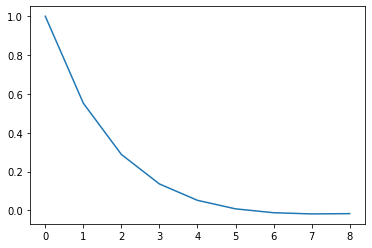

In [19]:
kernel = SkewKernel(alpha, l, odds)
kernel = kernel.to(output_device)
kernel.raw_log_lda = torch.nn.Parameter(torch.cat((torch.tensor([-100.]), -2*torch.arange(l))).to(output_device))

ker = kernel(x2[0].unsqueeze(0), x2).evaluate()
rho = ker.detach().cpu().numpy()[0]
rho /= rho[0]

from matplotlib import pyplot as plt
plt.plot(rho)
plt.show()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SkewVCModel(train_x, train_y, likelihood, kernel).to(output_device)

In [20]:
train_noise = np.array(dat['std'].iloc[train_ids])**2
train_noise = torch.tensor(train_noise, dtype=torch.float32).to(output_device)

In [21]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_noise, learn_additional_noise=True).to(output_device)

#### Test forward and backward pass

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), .1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [23]:
output = model(train_x)
loss = -mll(output, train_y)
print(loss)

KeyboardInterrupt: 

In [265]:
optimizer.zero_grad()
# Output from model
output = model(train_x)

loss = -mll(output, train_y)
print(loss)
loss.backward()
optimizer.step()

RuntimeError: CUDA out of memory. Tried to allocate 40.97 GiB (GPU 0; 79.35 GiB total capacity; 23.23 GiB already allocated; 3.02 GiB free; 72.68 GiB reserved in total by PyTorch)

#### Prediction on test data

/scratch/local/46511627/ipykernel_15763/1973996978.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


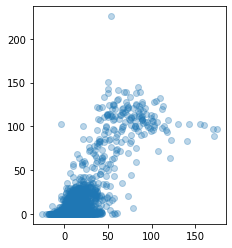

R2 = 0.661516
r2 = 0.661549


In [258]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

test_x = test_x.cuda()
model.eval()
likelihood.eval()

f_preds = model(test_x)

f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

# epistatic
# figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.axes().set_aspect('equal')
plt.show()
print('R2 = %f'%r2_score(y_test, f_mean))
print('r2 = %f'%pearsonr(y_test, f_mean)[0]**2)
# print('mse = %f'%mse(f_mean, y_test))

In [251]:
optimizer = torch.optim.AdamW(model.parameters(), .1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [256]:
checkpoint_size = 0
preconditioner_size = 100
model.train()

losses = train_model(model, likelihood, train_x, train_y, checkpoint_size, preconditioner_size, training_iter=8000, lr=.5)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
